In [ ]:
!pip install pystac_client==0.6.1 stackstac==0.4.4 planetary-computer

In [106]:
!planetarycomputer configure --subscription_key ""

Usage: planetarycomputer configure [OPTIONS]

  Configure the planetarycomputer library

Options:
  --subscription_key TEXT  Your API subscription key
  --help                   Show this message and exit.


In [34]:
bbox = Box(ymin=48.8155755, xmin=2.224122, ymax=48.902156, xmax=2.4697602)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [35]:
import os
import pystac_client
import planetary_computer
import stackstac
from shapely.geometry import Point, mapping

URL = 'https://planetarycomputer.microsoft.com/api/stac/v1/'
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    # intersects=mapping(Point(-2.254, 6.569)),
    collections=['sentinel-1-rtc'],
    datetime='2023-07-01/2023-08-31',
).item_collection()
items.items = [planetary_computer.sign(item) for item in items.items]
print('#items', len(items))

#items 11


In [36]:
data_array = stackstac.stack(items)
data_array

<xarray.DataArray 'stackstac-3ff74e26613f7f75a2216ce1584656b6' (time: 11,
                                                                band: 2,
                                                                y: 29491,
                                                                x: 43756)>
dask.array<fetch_raster_window, shape=(11, 2, 29491, 43756), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2023-07-03T0...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2023...
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 2.067e+05 ... 6.443e+05
  * y                                      (y) float64 5.561e+06 ... 5.266e+06
    start_datetime                         (time) <U32 '2023-07-03 06:07:46.3...
    ...                                     ...
    platform                               <U11 'SENTINEL-1A'
    sar:looks_azimuth                      int64 1
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  (band) <U41 'VH: vertical transmit...
    description                            (band) <U173 'Terrain-corrected ga...
    epsg                                   int64 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(206720.0, 5265890.0, 644280.0...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 206720.00|\n| 0.00,-10.00, 5560800.00|\n| 0.0...
    resolution:  10.0

In [12]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.evaluation import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda:0'

In [37]:
crs_transformer = RasterioCRSTransformer(
    transform=data_array.transform, image_crs=data_array.crs)

In [38]:
raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    channel_order=list(range(len(data_array.band))),
    temporal=True
)
raster_source.shape

(11, 29491, 43756, 2)

In [39]:
T = raster_source.shape[0]
t_strs = np.array([str(_t.date()) for _t in raster_source.data_array.time.to_series().to_list()])

In [40]:
window = raster_source.extent.get_windows(500, 500)[0]
window

Box(ymin=0, xmin=0, ymax=500, xmax=500)

In [63]:
window = Box(ymin=11800, xmin=9500, ymax=12300, xmax=10000)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.07s/it]


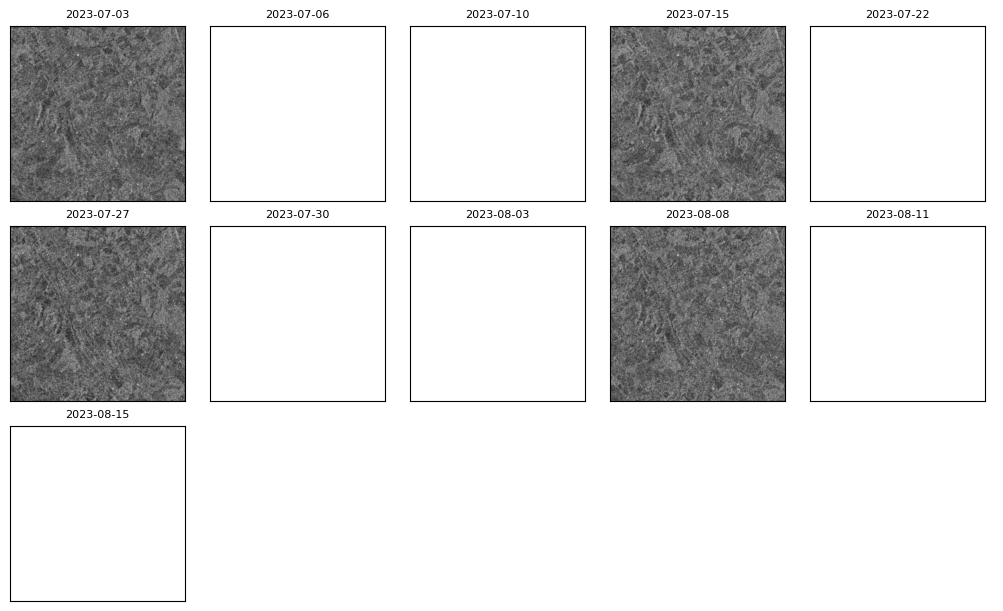

In [84]:
plt.close('all')

skip = 1
ts = range(0, T, skip)
t_strs_ = t_strs[::skip]

ncols = 5
nrows = int(math.ceil(len(ts) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)
with tqdm(zip(ts, t_strs_, axs.flat), total=len(ts)) as bar:
    for t, t_str_t, ax in bar:
        chip_t = raster_source.get_chip(window, bands=[0], time=t).squeeze()
        ax.imshow(np.log(chip_t), cmap='gray')
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(t_str_t, fontsize=8)

if t < len(axs.flat) - 1:
    for ax in axs.flat[t + 1:]:
        ax.axis('off')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.47s/it]


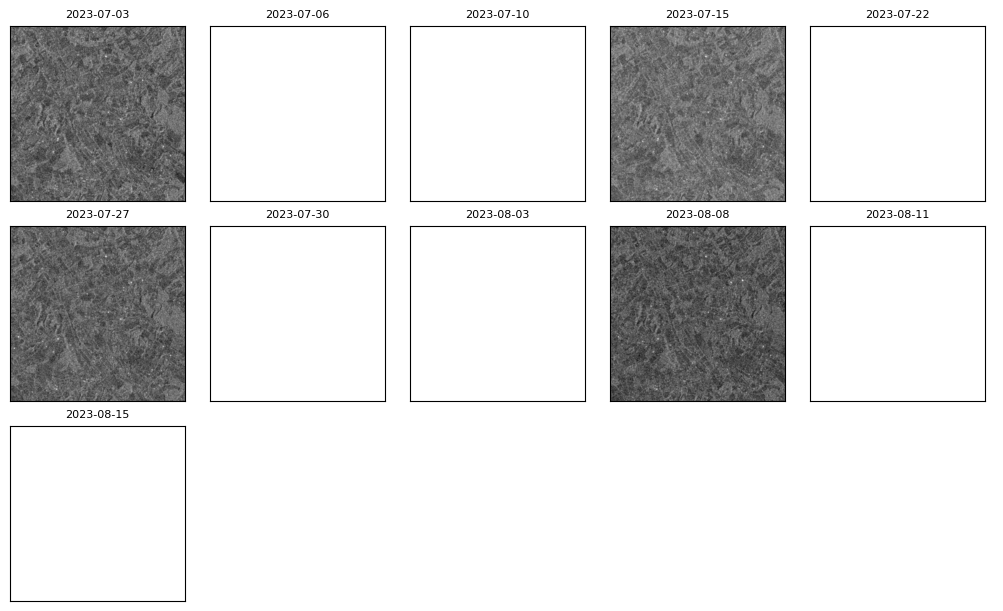

In [105]:
plt.close('all')

skip = 1
ts = range(0, T, skip)
t_strs_ = t_strs[::skip]

ncols = 5
nrows = int(math.ceil(len(ts) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)
with tqdm(zip(ts, t_strs_, axs.flat), total=len(ts)) as bar:
    for t, t_str_t, ax in bar:
        chip_t = raster_source.get_chip(window, bands=[1], time=t).squeeze()
        ax.imshow(np.log(chip_t), cmap='gray')
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(t_str_t, fontsize=8)

if t < len(axs.flat) - 1:
    for ax in axs.flat[t + 1:]:
        ax.axis('off')
plt.show()

In [47]:
from rastervision.core.data import RasterioSource

In [85]:
rs = RasterioSource('/home/adeel/Downloads/iw-vv.rtc.tiff')

In [86]:
rs.shape

(21180, 29015, 1)

In [87]:
rs.crs_transformer.map_to_pixel(bbox).normalize()

Box(ymin=11409, xmin=8896, ymax=12356, xmax=10706)

In [88]:
window = Box(ymin=11800, xmin=9500, ymax=12300, xmax=10000)
# window = rs.crs_transformer.map_to_pixel(bbox).normalize()
chip = rs.get_chip(window)
chip.min(), chip.max()

(0.006988491, 16933.11)

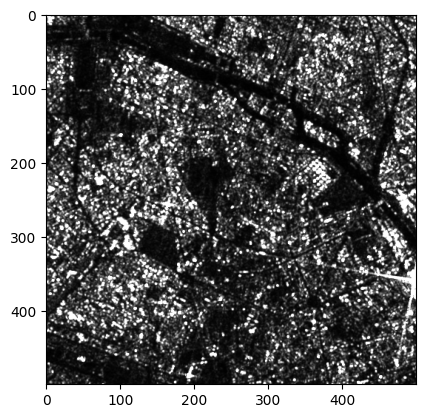

In [62]:
plt.imshow(np.minimum(1, chip.squeeze()), cmap='gray')
plt.show()

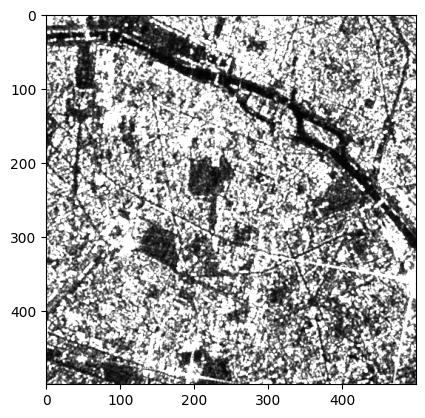

In [89]:
plt.imshow(np.minimum(1, chip.squeeze()), cmap='gray')
plt.show()

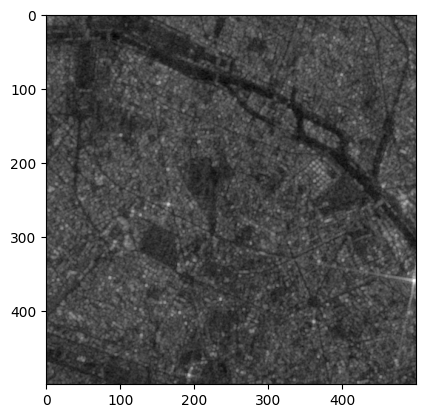

In [82]:
plt.imshow(np.log(chip.squeeze()), cmap='gray')
plt.show()

In [103]:
stats_tf = StatsTransformer(means=[np.log(chip).mean()], stds=[np.log(chip).std()])
stats_tf

StatsTransformer(means=array([-0.50705338]), std=array([1.15931368]), max_stds=3.0)

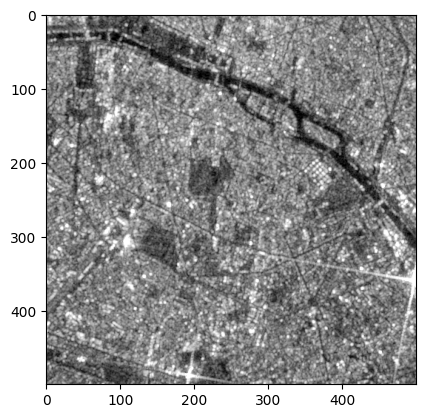

In [104]:
plt.imshow(stats_tf.transform(np.log(chip)).squeeze(), cmap='gray')
plt.show()

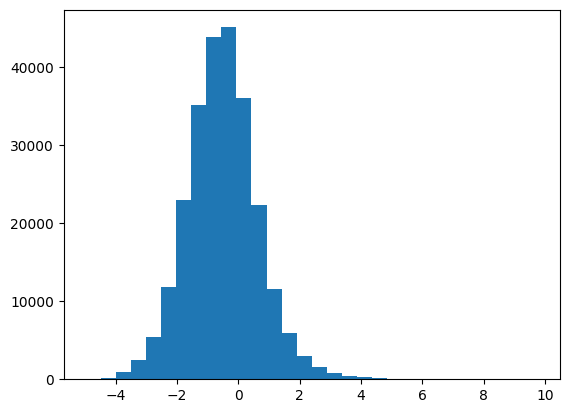

In [97]:
plt.hist(np.log(chip).flat, bins=30)
plt.show()